In [ ]:
#
# Things to add:
#
# A.) 1. Prepare and 3. Debrief
# B.) Word counts (for everything)
# C.) Spread for cycle metrics (box plots)
# D.) Cycle metrics over time
# E.) Make everything functions instead of loops.
#

In [ ]:
#
# Steps to run:
#
# 1.) Run the Google Drive API Python Quickstart: https://developers.google.com/drive/api/v3/quickstart/python
# 2.) Run the Google Sheets API Python Quickstart: https://developers.google.com/sheets/api/quickstart/python
# 3.) Put this notebook in the same path as your token.json files.
# 4.) Make sure this notebook is calling the correct token.json files (in sheets_token_path and drive_token_path below).
# 5.) Run notebook!
#

In [ ]:
#
# Notes:
#
# This is optimized for the Work Cycles v2.2 sheet.
#
# The following elements are hardcoded:
# A.) Filters sheets containing 'Ultraworking' in title.
# B.) Calls sheets by '1. Prepare', '2. Work', '3. Debrief'.
# C.) Extracting data and order of features.
#

In [61]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

# from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import display

In [ ]:
# This runs the quickstart2.py, creating token.json (if you don't have it).
# !python /Users/sam/Desktop/projects/quickstart2.py

In [ ]:
# Get all Sheets using Google Drive API.

# from __future__ import print_function
from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

item_df = []

page_token = None

store = file.Storage('token.json')
creds = store.get()
        
service = build('drive', 'v3', http=creds.authorize(Http()))

while True:
    
    # Gets all Sheets
    response = service.files().list(q = "mimeType = 'application/vnd.google-apps.spreadsheet'",
                                          fields = 'nextPageToken, files(name, id, createdTime)',
                                          pageToken = page_token).execute()
    
    for file in response.get('files', []):
        item_df.append(file)
        
    page_token = response.get('nextPageToken', None)
    
    if page_token is None:
        break

In [ ]:
# pretty up the df
items = pd.DataFrame(item_df)
items['createdTime'] = pd.to_datetime(items['createdTime'])
items = items[['name', 'id', 'createdTime']]

# filter to UW sheets
uw_df = items[items['name'].str.contains('Ultraworking')]
uw_df.reset_index(inplace=True)

uw_df

In [ ]:
# # makes token_sheets.json if not already
# !python /Users/sam/Desktop/projects/quickstart_sheets.py

In [21]:
# Read work sheets from Google Sheets using ids.

# from __future__ import print_function
from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

# If modifying these scopes, delete the file token.json.
SCOPES = 'https://www.googleapis.com/auth/spreadsheets.readonly'

#
# Change this function to reference sheet 1., 2., 3. etc.
#

def main(spreadsheet_id, sheet):
    
    store = file.Storage('token_sheets.json')
    creds = store.get()
        
    service = build('sheets', 'v4', http = creds.authorize(Http()))
    
    sheet_metadata = service.spreadsheets().get(spreadsheetId = spreadsheet_id).execute()
    sheets = sheet_metadata.get('sheets', '')
    
    #titles = [x.get("properties", {}).get("title") for x in sheets]
    
    # 2. Work
    
    SAMPLE_RANGE_NAME = '{}!A:J'.format(sheet)
    
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId = spreadsheet_id,
                                range = SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    
#     users = sheet_metadata['sheets'][0]['protectedRanges'][0]['editors']['users']
#     users = dict([users])
    
    return values

# values = main(SAMPLE_SPREADSHEET_ID)

In [ ]:
# Map energy, morale, and completion to numeric.

energy_morale_dict = {
    'High': 2,
    'Medium': 1,
    'Low': 0
}

completion_dict = {
    'Yes': 2,
    'Half': 1,
    'No': 0
}

In [ ]:
#
# This bit below works exclusively for sheet 2.
# Needs separate functions for sheet 1. and sheet 3.
#

In [62]:
# Concat all sheets.

main_df = pd.DataFrame()

for x in uw_df['id']:
        
    try:
        
        print('{}/{} - {}'.format(uw_df.loc[uw_df['id'] == x].index.values[0], len(uw_df), uw_df.loc[uw_df['id'] == x, 'name'].values[0]))

        values = main(x, '2. Work')

        contents = []

        for z in values:
            if len(z) > 1:
                contents.append(z[2:])
            else:
                pass
            
        # Underscores to distinguish metrics from vectorized strings.
        header = ['time_',
                  'cycle_',
                  'goal_',
                  'start_',
                  'hazards_',
                  'energy_',
                  'morale_',
                  'completion_',
                  'notes_',
                  'distractions_',
                  'improvements_']

        df = pd.DataFrame(contents).T
        df.columns = header
        
        df['energy_'] = df['energy_'].map(energy_morale_dict)
        df['morale_'] = df['morale_'].map(energy_morale_dict)
        df['completion_'] = df['completion_'].map(completion_dict)

        time = uw_df.loc[uw_df['id'] == x, 'createdTime'].values[0]
        df['timeCreated'] = [time]*len(df)
        df['timeCreated'] = pd.to_datetime(df['timeCreated'])

        main_df = pd.concat([main_df, df], axis=0)
    
    except:
        
        print(' ', 'Exception:', uw_df.loc[uw_df['id'] == x, 'name'].values[0])
        
main_df.reset_index(inplace=True, drop=True)
# main_df.head()

0/14 - Copy of [BLANK] Ultraworking - Work Cycles v2.2
  Exception: Copy of [BLANK] Ultraworking - Work Cycles v2.2
1/14 - Copy of [BLANK] Ultraworking - Work Cycles v2.2
  Exception: Copy of [BLANK] Ultraworking - Work Cycles v2.2
2/14 - [BLANK] Ultraworking - Work Cycles v2.2
  Exception: [BLANK] Ultraworking - Work Cycles v2.2
3/14 - 181120 - Ultraworking Work Cycles v2.2
4/14 - 181209 Ultraworking - Work Cycles v2.2
5/14 - 181207 Ultraworking - Work Cycles v2.2
6/14 - 181206 Ultraworking - Work Cycles v2.2
7/14 - 181206_2 Ultraworking - Work Cycles v2.2
8/14 - 181205_2 Ultraworking - Work Cycles v2.2
  Exception: 181205_2 Ultraworking - Work Cycles v2.2
9/14 - 181205 Ultraworking - Work Cycles v2.2
10/14 - TWG 5 Dec Demo Copy of Ultraworking - Work Cycles v2.2
11/14 - 181128 Ultraworking - Work Cycles v2.2
12/14 - 181124 Ultraworking - Work Cycles v2.2
13/14 - 181121 Ultraworking - Work Cycles v2.2


In [63]:
# Drops some features to make everything cleaner.
main_df.drop(
    [
        'start_', 
        'hazards_', 
        'distractions_', 
        'improvements_'
    ], 
    axis=1, 
    inplace=True
)

In [64]:
# Maps 'time' and 'cycle' to numeric values.
cycle_map = {
    'Cycle 1': 1,
    'Cycle 2': 2,
    'Cycle 3': 3,
    'Cycle 4': 4,
    'Cycle 5': 5,
    'Cycle 6': 6,
}

main_df['cycle_'] = main_df['cycle_'].map(cycle_map)
main_df['time_'] = pd.to_datetime(main_df['time_']).dt.time
main_df['hour_'] = [x.hour for x in main_df['time_']]

In [65]:
# Gets wordcount for features

def get_wordcount(feature):   
    wordcount_feature = []   
    for string in feature:       
        if string == None:
            wordcount = 0
        else:
            wordcount = len(string.split())
        wordcount_feature.append(wordcount)        
    return wordcount_feature
        
for x in [
    'goal_', 
    'notes_'
]:
    main_df[str(x) + 'wc_'] = get_wordcount(main_df[x])

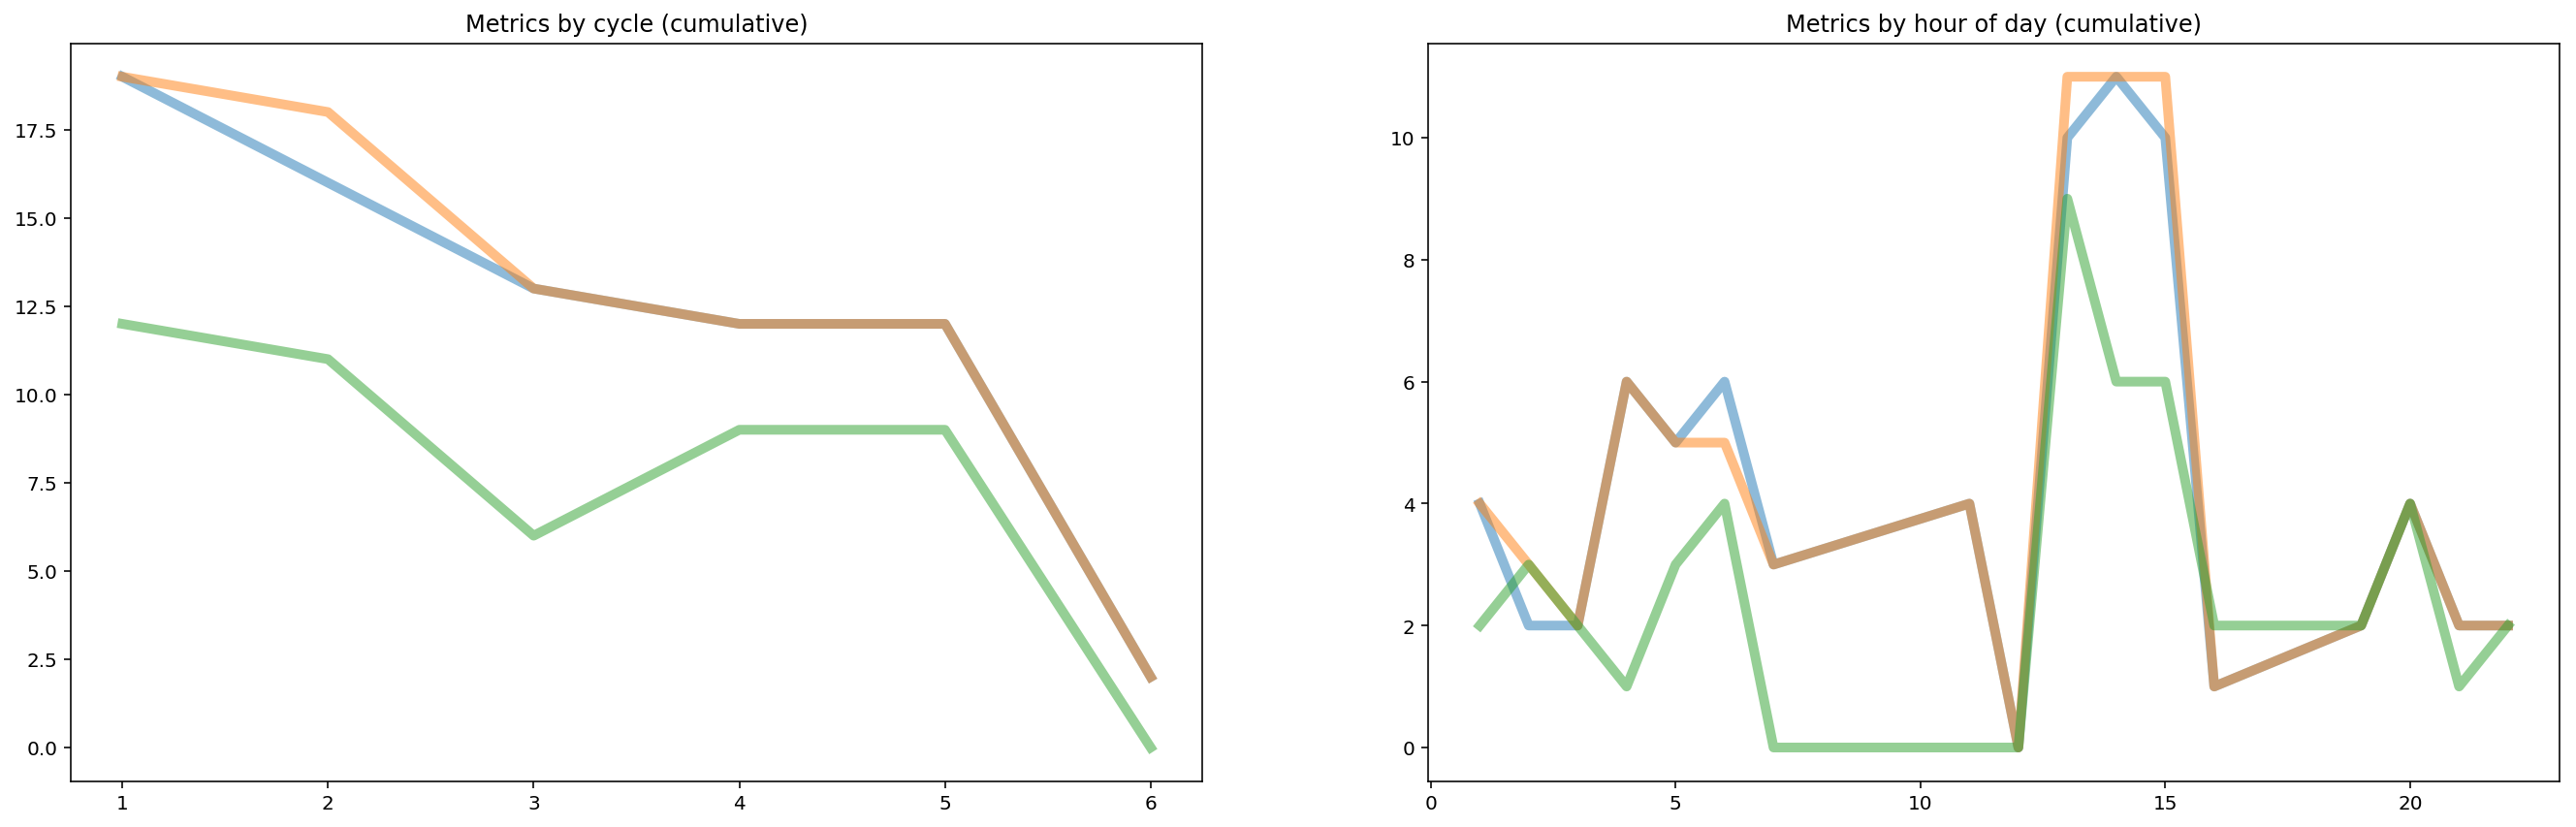

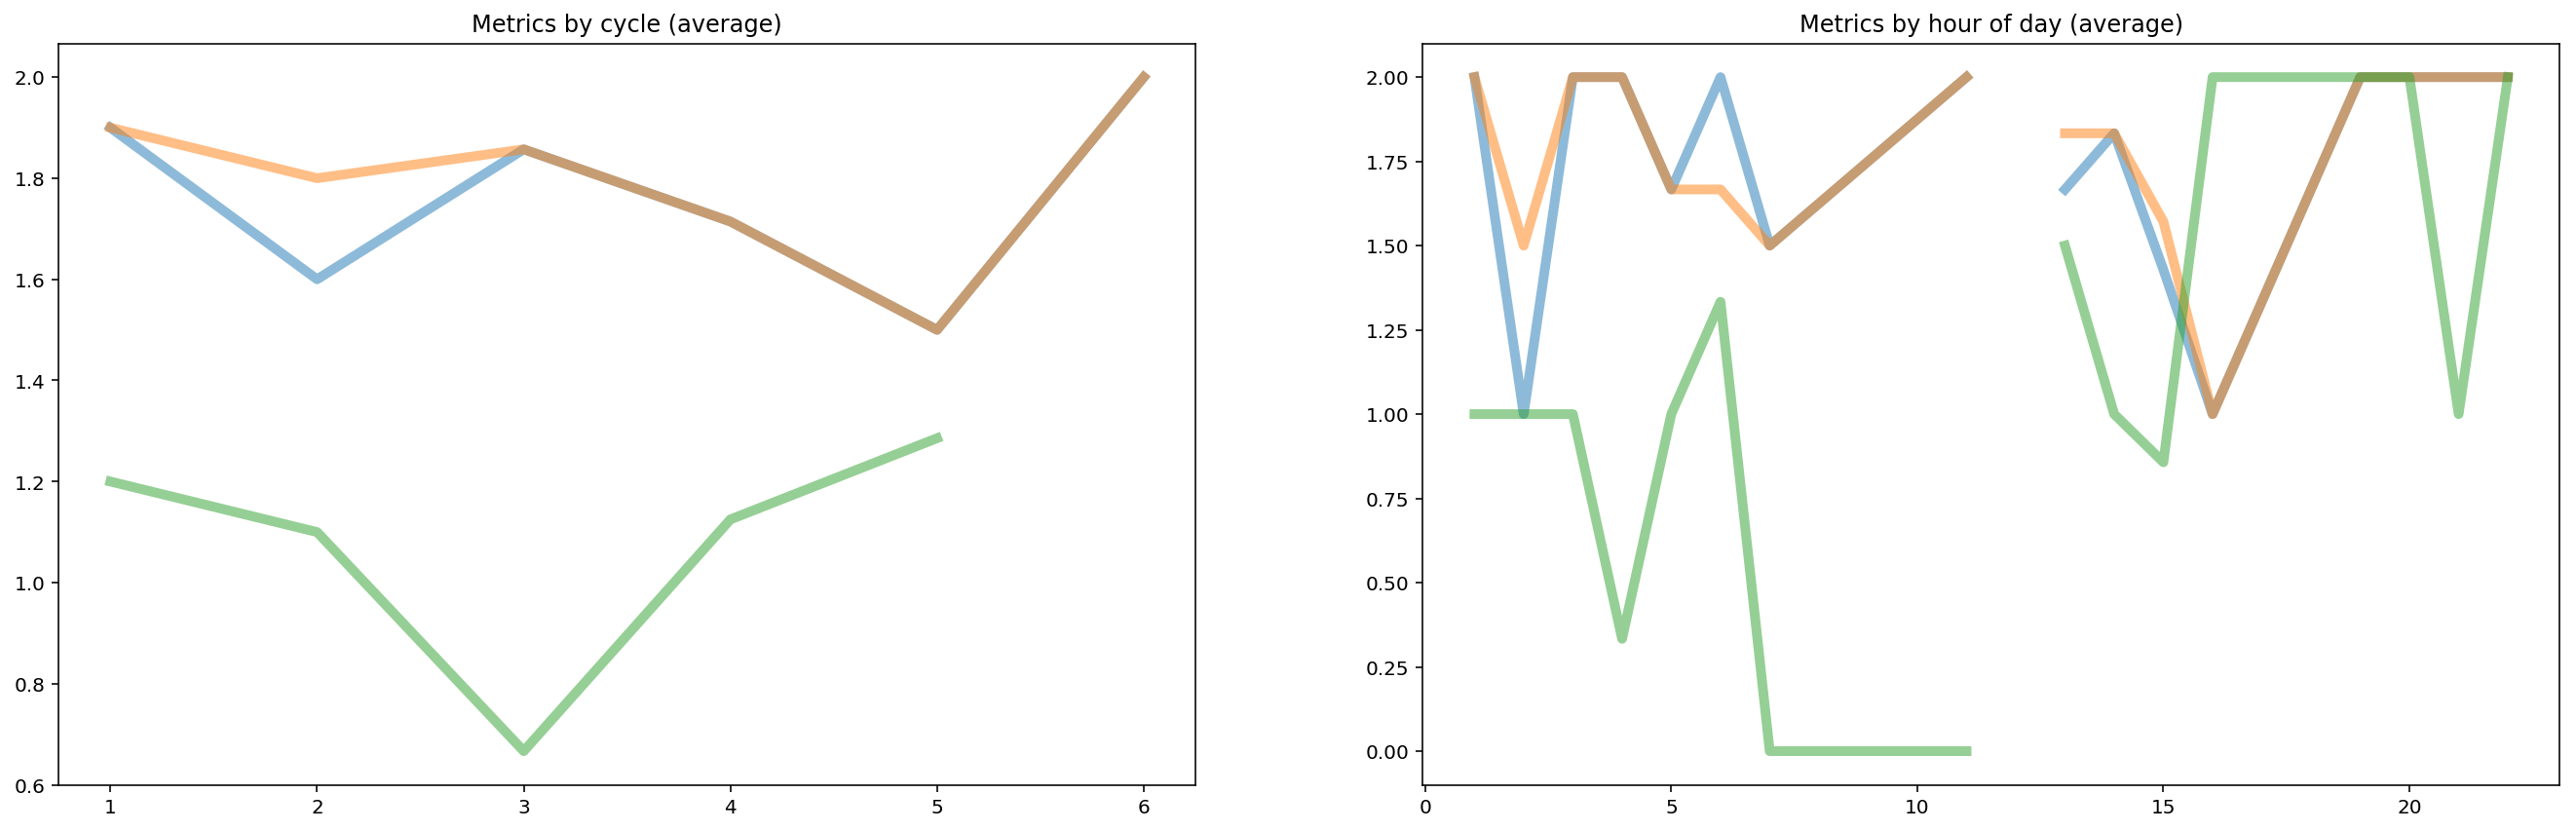

In [99]:
# Metrics over time

plt.figure(figsize=(23, 7))
# sp1
plt.subplot(121)
plt.plot(main_df.groupby(by='cycle_').sum()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by cycle (cumulative)')
# sp2
plt.subplot(122)
plt.plot(main_df.groupby(by='hour_').sum()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by hour of day (cumulative)')
plt.show()

plt.figure(figsize=(23, 7))
# sp1
plt.subplot(121)
plt.plot(main_df.groupby(by='cycle_').mean()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by cycle (average)')
# sp2
plt.subplot(122)
plt.plot(main_df.groupby(by='hour_').mean()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by hour of day (average)')
plt.show()

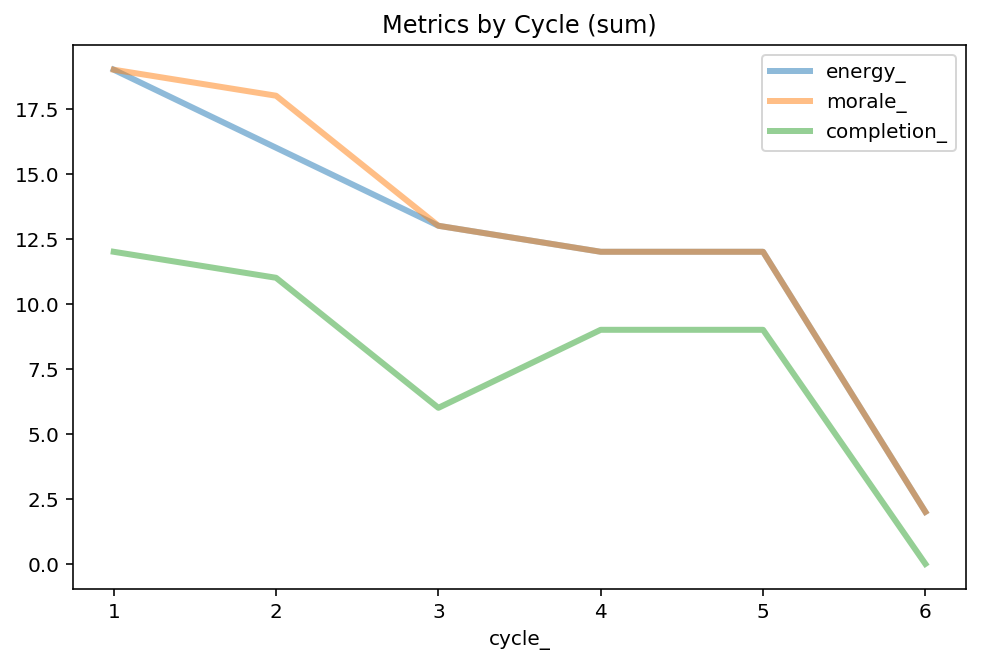

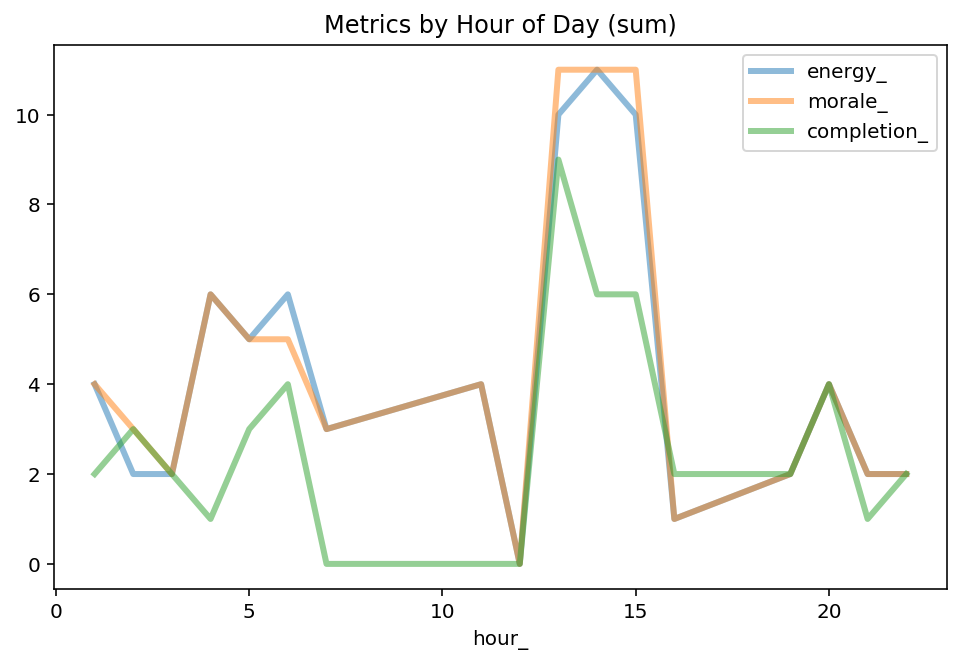

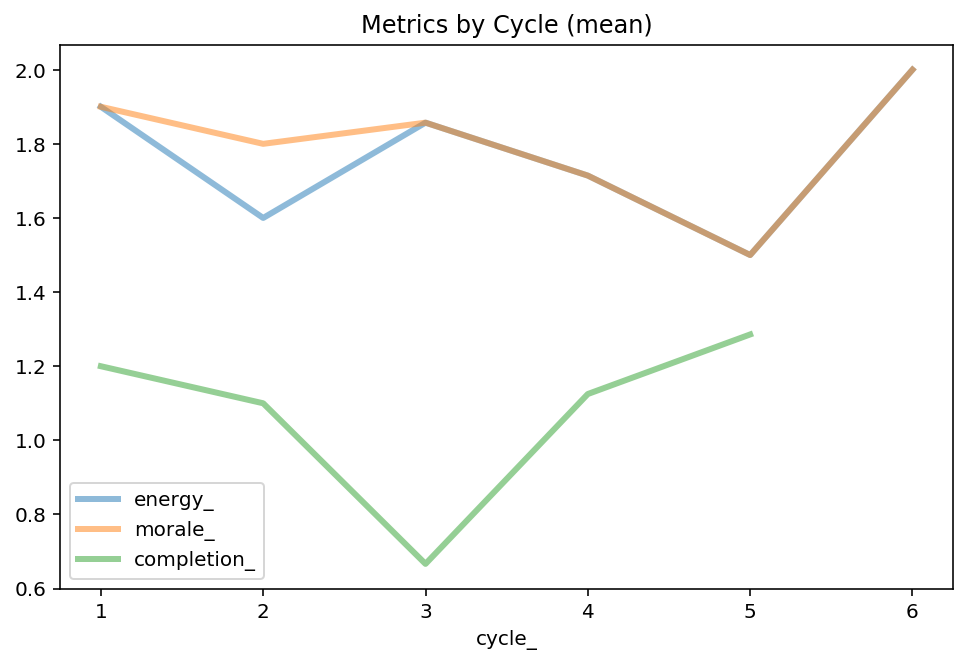

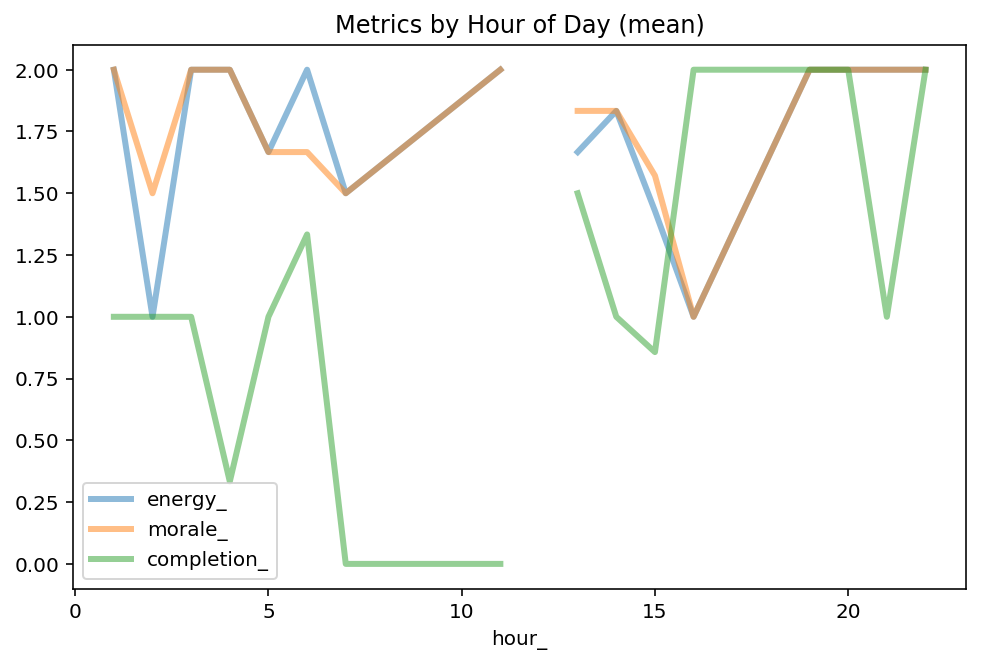

In [29]:
#
# Change this to plot things next to each other.
# 
# Add cycle spreads and cycle histories here.
# 


main_df.groupby(by='cycle_').sum()[['energy_', 'morale_', 'completion_']].plot(alpha=.5, 
                                                                                lw=3, 
                                                                                figsize=(8,5), 
                                                                                title='Metrics by Cycle (sum)');
main_df.groupby(by='hour_').sum()[['energy_', 'morale_', 'completion_']].plot(alpha=.5, 
                                                                               lw=3, 
                                                                               figsize=(8,5), 
                                                                               title='Metrics by Hour of Day (sum)');
main_df.groupby(by='cycle_').mean()[['energy_', 'morale_', 'completion_']].plot(alpha=.5, 
                                                                                lw=3, 
                                                                                figsize=(8,5), 
                                                                                title='Metrics by Cycle (mean)');
main_df.groupby(by='hour_').mean()[['energy_', 'morale_', 'completion_']].plot(alpha=.5, 
                                                                               lw=3, 
                                                                               figsize=(8,5), 
                                                                               title='Metrics by Hour of Day (mean)');

In [30]:
#
# Add word counts in here.
#


# Replaces null strings
def prep(string):
    if string == None:
        string = 'None'
    return string

# Gets stats
def get_stats(main_df_column, metric):
    
    corpus = [prep(i) for i in main_df[main_df_column]]
    vec = CountVectorizer(ngram_range=(1,1), 
                          stop_words='english')
    fit_vec = vec.fit_transform(corpus)
    vec_df = pd.DataFrame(fit_vec.todense(), columns=vec.get_feature_names())
    
    # Concat with metric
    goal_df = pd.concat([main_df[metric], vec_df], axis=1)
    new_df = goal_df.groupby(metric).sum().T
        
    metric_map = {
        0.0: 'low',
        1.0: 'medium',
        2.0: 'high'
    }
    
    new_df.columns = new_df.columns.map(metric_map)
        
    print('Keywords by {} for {}:'.format(metric, main_df_column))
    
    metric_df = pd.concat([pd.DataFrame(new_df.sort_values(by=x, ascending=False)[x].head(10)).rename_axis(x+'_kws').reset_index() for x in new_df.columns], axis=1)

    # Comment this out to remove total top keywords
    #metric_df = pd.concat([get_top(main_df_column), metric_df], axis=1)

    return metric_df
    
# Get top words 
def get_top(main_df_column):
    
    corpus = [prep(i) for i in main_df[main_df_column]]
    vec = CountVectorizer(ngram_range=(1,1), 
                          stop_words='english')
    fit_vec = vec.fit_transform(corpus)
    vec_df = pd.DataFrame(fit_vec.todense(), columns=vec.get_feature_names())
    
    return pd.DataFrame(vec_df.sum().sort_values(ascending=False).head(10), columns=['count']).rename_axis('top kws').reset_index()

In [32]:
# Print results

freeform = [
    'goal_',
#     'start_', 
#     'hazards_', 
    'notes_', 
#     'distractions_', 
#     'improvements_'
]

metrics = [
#     'energy_',
#     'morale_', 
    'completion_'
]

for x in freeform:
    for y in metrics: 
        display(get_stats(x, y))

Keywords by completion_ for goal_:


,low_kws,low,medium_kws,medium,high_kws,high
0,model,4,strategy,3,list,2
1,print,4,options,3,expenses,2
2,delta,3,try,3,example,2
3,options,3,code,3,reconcile,2
4,figure,3,filter,3,code,2
5,run,3,make,3,ec2,2
6,sheets,3,example,2,dte,2
7,api,2,connect,2,drive,2
8,sync,2,check,2,streaming,2
9,option,2,upwork,2,stuff,2


Keywords by completion_ for notes_:


,low_kws,low,medium_kws,medium,high_kws,high
0,got,4,got,6,started,4
1,ec2,3,did,4,got,4
2,drive,2,started,3,finished,4
3,debugging,2,just,3,google,3
4,space,2,cycle,2,mounted,2
5,filtering,2,closest,2,credentials,2
6,closest,2,forward,2,s3,2
7,trying,2,finished,2,api,2
8,shit,2,finish,2,good,2
9,loading,2,filtered,2,shit,2


In [33]:
main_df

,time_,cycle_,goal_,energy_,morale_,completion_,notes_,timeCreated,hour_
0,13:50:00,1,Get image streaming working,1.0,1.0,1.0,"I felt like I moved the ball forward, I did no...",2018-11-20 21:21:42.432,13
1,14:30:00,2,Continue with the example image streaming code...,1.0,1.0,2.0,"Finished example code, haven't implemented ful...",2018-11-20 21:21:42.432,14
2,15:10:00,3,Run on full set,2.0,2.0,0.0,"Ran into problems with train/test, spent much ...",2018-11-20 21:21:42.432,15
3,15:50:00,4,Keep debugging train test gen,2.0,2.0,2.0,Breakthrough shit,2018-11-20 21:21:42.432,15
4,16:30:00,5,"Finish e-mail (open Apex e-mails, click throug...",1.0,1.0,2.0,None,2018-11-20 21:21:42.432,16
5,02:15:00,1,Codecademy SQL lesson,2.0,2.0,2.0,Listened to Josh Waitzkin at Google,2018-11-21 20:59:56.959,2
6,02:55:00,2,Codecademy SQL lesson,0.0,1.0,1.0,Broke halfway through for sleep.,2018-11-21 20:59:56.959,2
7,14:15:00,3,"A.) Google Docs journal, B.) Connect with anal...",2.0,2.0,1.0,"Finished A.), didn't finish B.) but got gains",2018-11-21 20:59:56.959,14
8,14:55:00,4,"A.) connect on LinkedIn, B.) check upwork",2.0,2.0,1.0,"Got the connect on LinkedIn, then got diverted...",2018-11-21 20:59:56.959,14
9,15:35:00,5,"A.) Update profile, B.) If you're done with th...",2.0,2.0,2.0,Finished A). Not sure I started timer.,2018-11-21 20:59:56.959,15
